In [1]:
# Notebook: Sentimentanalyse von Finanznachrichten
# Dieses Notebook zeigt exemplarisch:
# - wie Finanznachrichten (CSV-Daten) eingelesen, 
# - bereinigt und 
# - mit einer Sentimentanalyse versehen werden.
#
# Datenhinweis:
# - Daten sind hier NICHT enthalten, sondern müssen extern bereitgestellt werden.

In [2]:
# Bibliotheken laden
import pandas as pd # Für die Arbeit mit Tabellen und CSV-Dateien
import re # Für Regular Expressions
import numpy as np # Für Berechnungen
import matplotlib.pyplot as plt # Für die Visualisierung
import plotly.graph_objects as go # Für die Visualisierung
import plotly.express as px # Für die Visualisierung
from transformers import pipeline # Sentimentanalyse
import time

In [6]:
# Datei einlesen
# Erwartet: CSV mit Spalten ["Datum", "Titel", "Quelle", "Sprache"]
df_FinanzNews_DE = pd.read_csv("Finanznachrichten.csv", encoding='utf-8')

In [7]:
# Einheitliche Farben für alle Unternehmen
farben_unternehmen = {
    "SAP": "#006BB8",         # Blau
    "Siemens": "#009999",     # Grün
   "Allianz": "#ff7f0e",     # Orange
    "Telekom": "#E20074",     # Magenta
      "Rheinmetall": "#3E3D40"  # Grau
}

In [8]:
# Datum in datetime-Format umwandeln
df_FinanzNews_DE["Datum"] = pd.to_datetime(df_FinanzNews_DE["Datum"], format="%Y-%m-%d")
# Überprüfung, ob Zeitraum korrekt ist
print(df_FinanzNews_DE["Datum"].min(), df_FinanzNews_DE["Datum"].max())

2020-01-01 00:00:00 2025-06-09 00:00:00


In [9]:
# Zeigt Spaltennamen, Datentypen, Anzahl nicht-leerer Einträge und Anzahl der eindeutigen Werte
struktur_dfFinanzNews = pd.DataFrame({
    "Spalte": df_FinanzNews_DE.columns,
    "Datentyp": df_FinanzNews_DE.dtypes.values,
    "Nicht-Null Werte": df_FinanzNews_DE.notnull().sum().values,
    "Anzahl eindeutiger Werte": df_FinanzNews_DE.nunique().values
})
struktur_dfFinanzNews.style.set_caption("Struktur der Finanznachrichten-Daten")

,Spalte,Datentyp,Nicht-Null Werte,Anzahl eindeutiger Werte
0,Datum,datetime64[ns],220899,1962
1,Titel,object,220899,208730
2,Quelle,object,220899,295
3,Sprache,object,220899,1


In [10]:
# Erstellt eine Häufigkeitstabelle für alle Jahre
jahres_counts = df_FinanzNews_DE["Datum"].dt.year.value_counts().sort_index()
jahres_df = jahres_counts.reset_index()
jahres_df.columns = ["Jahr", "Anzahl Artikel"]
display(jahres_df)

,Jahr,Anzahl Artikel
0,2020,48160
1,2021,51285
2,2022,46098
3,2023,36251
4,2024,33422
5,2025,5683


In [11]:
# Mapping von Unternehmensnamen auf typische Schreibweisen in Nachrichtentiteln (RegEx-Muster)
# Ziel: Identifikation von Artikeln, die sich auf ein bestimmtes Unternehmen beziehen

unternehmen_mapping = {
    "SAP": [
        r"\bSAP\b",         # genaues Wort "SAP"
        r"\bSAP-",          # Bindestrich-Konstruktionen wie "SAP-Aktie"
        r"\bSAPs?\b"        # auch Plural-/Besitzformen wie "SAPs"
    ],
    "Siemens": [
        r"\bSiemens\b", 
        r"\bSiemens-", 
        r"\bEx-Siemens-"    # z. B. "Ex-Siemens-Manager"
    ],
    "Rheinmetall": [
        r"\bRheinmetall\b"
    ],
    "Telekom": [
        r"\bTelekom\b", 
        r"\bDeutsche Telekom\b"
    ],
    "Allianz": [
        r"\bAllianz\b", 
        r"\bAllianz-", 
        r"\bdie Allianz\b"  # Artikelkonstruktionen wie "die Allianz kündigt ..."
    ]
    # Achtung: keine Muster, die auch "Allianzen" oder allgemeine Begriffe erfassen
}

In [12]:
# Funktion zur automatisierten Erkennung von Unternehmensnennungen in den Nachrichtentiteln
# Nutzt reguläre Ausdrücke (mapping), um typische Schreibweisen pro Unternehmen zu erkennen

def finde_unternehmen(text, mapping):
    gefundene = []
    for firma, muster_liste in mapping.items():
        for muster in muster_liste:
            # Suche nach dem Muster (unabhängig von Groß-/Kleinschreibung)
            if re.search(muster, text, flags=re.IGNORECASE):
                gefundene.append(firma)  # Firma zur Trefferliste hinzufügen
                break  # Bei erstem Treffer abbrechen, um Doppeleintrag zu vermeiden
    return gefundene  # Gibt Liste mit allen im Text erkannten Unternehmen zurück

In [13]:
# Wendet die Funktion 'finde_unternehmen' auf jeden Nachrichtentitel an
# Ziel: Automatisch erkennen, welche der definierten Unternehmen im Titel erwähnt werden
# Ergebnis wird in einer neuen Spalte 'Gefundene_Unternehmen' gespeichert (als Liste)

df_FinanzNews_DE["Gefundene_Unternehmen"] = df_FinanzNews_DE["Titel"].apply(
    lambda x: finde_unternehmen(str(x), unternehmen_mapping)
)

In [14]:
# Neuer Dataframe mit relevanten Unternehmen und in einem neuen Datensatz speichern
df_FinanzNews_DE_Unternehmen = df_FinanzNews_DE[
    df_FinanzNews_DE["Gefundene_Unternehmen"].str.len() > 0
].drop(columns=["Sprache"]).copy()

In [15]:
# Überprüfung anhand einer zufällige Stichprobe von 20 Nachrichten mit den zugeordneten Unternehmen
df_FinanzNews_DE_Unternehmen[["Titel", "Gefundene_Unternehmen"]].sample(20).style.set_properties(
    subset=["Titel"], **{"white-space": "normal", "text-align": "left"}
)

,Titel,Gefundene_Unternehmen
175823,Deutsche Telekom vor den Zahlen - das müssen Anleger jetzt wissen,['Telekom']
97897,Allianz: In der Weihnachtszeit mehr Transportschäden,['Allianz']
63436,"SAP, TUI, Commerzbank und Bitcoin Group im Fokus",['SAP']
144837,"Rheinmetall Aktie meldet sich zurück. Düsseldorfer geben Puma-Milliardenauftrag noch lange nicht verloren. 2023 wieder über 200,00 EUR?",['Rheinmetall']
205525,Rheinmetall und Hensoldt: Rüstungsaktien knicken ein. Neue Kursziele,['Rheinmetall']
115061,SAP nach Zahlen: Der Befreiungsschlag bleibt aus,['SAP']
119543,"Woche mit Börsen News - mit 14.462,9 Punkten hoffnungsfroh ins Wochenende. Rheinmetall, Varta, Steinhoff, Plug Power, Enapter, Verbio, S&T, u.a. mit News",['Rheinmetall']
25700,GOLDMAN SACHS belässt RHEINMETALL AG auf 'Buy',['Rheinmetall']
109240,"Investment-Schnelltest inkl. BASF, Siemens, CrowdStrike, Snowflake usw.",['Siemens']
64596,"Plug Power, Ballard Power, JinkoSolar, Nordex, SAP, VW, Daimler: Marktbericht Themendepot Zukunftstechnologien",['SAP']


In [16]:
# Sentimentanalyse
# Nutzung von German FinBert von Scherrmann (2023)

# Initialisiere eine Sentimentanalyse-Pipeline mit dem spezialisierten Modell "GermanFinBert_SC_Sentiment"
pipe = pipeline(
    "text-classification",  # Aufgabe: Textklassifikation (hier: Sentimentanalyse)
    model="scherrmann/GermanFinBert_SC_Sentiment", # Name des vortrainierten Modells auf Hugging Face
    device=0,         # Nutzt GPU (falls vorhanden), 0 = erste CUDA-GPU
    batch_size=32     # Verarbeitung in Blöcken von 32 Texten gleichzeitig (Effizienzsteigerung)
)

Device set to use mps:0


In [17]:
# Test, ob die Textklassifikation mithilfe des Modells funktioniert
pipe(["SAP überrascht mit Quartalszahlen", "Allianz verliert an Wert"])

[{'label': 'Positiv', 'score': 0.99111008644104},
 {'label': 'Negativ', 'score': 0.985958993434906}]

In [18]:
# Durchführung der Sentimentanalyse der Nachrichtentitel mit German FinBERT
# 1. Liste aller Titel
titel_liste = df_FinanzNews_DE_Unternehmen["Titel"].tolist()

# 2. Durchsatz testen
sample = titel_liste[:100]
start = time.time()
_ = pipe(sample, batch_size=32)
print("Durchsatz:", len(sample)/(time.time()-start), "Titel/s")

# 3. Ergebnisse direkt in einem Rutsch berechnen (Batching intern)
results = pipe(titel_liste, batch_size=32)

# 4. Label und Score extrahieren
labels      = [r["label"] for r in results]
confidences = [r["score"] for r in results]

# 5. In den DataFrame schreiben
df_FinanzNews_DE_Unternehmen["sentiment"]  = labels
df_FinanzNews_DE_Unternehmen["confidence"] = confidences

Durchsatz: 140.2987001735711 Titel/s


In [19]:
# Sentiment in numerischen Wert umwandeln
# Mapping-Tabelle erstellen
sentiment_map = {'Negativ': -1, 'Neutral': 0, 'Positiv': 1}

# Das Mapping wird auf die 'sentiment'-Spalte des DataFrames angewendet.
# Das Ergebnis wird als neue Spalte 'sentiment_num' gespeichert.
# Dadurch wird die spätere numerische Analyse (z. B. Mittelwert, Korrelation, Visualisierung) deutlich einfacher.
df_FinanzNews_DE_Unternehmen['sentiment_num'] = df_FinanzNews_DE_Unternehmen['sentiment'].map(sentiment_map)
# Gibt die neue Spalte mit den numerischen Sentiment-Werten aus, um das Ergebnis zu überprüfen.
print(df_FinanzNews_DE_Unternehmen['sentiment_num'])

422       0
570       0
629       1
688      -1
758       1
         ..
220174    0
220356    0
220575   -1
220702    0
220733    0
Name: sentiment_num, Length: 2695, dtype: int64


In [20]:
# Deskriptive Analysen

# Häufigkeitstabelle der Medien für alle Jahre
quelle_counts = df_FinanzNews_DE_Unternehmen["Quelle"].value_counts().head(20)
quelle_df = quelle_counts.reset_index()
quelle_df.columns = ["Quelle", "Anzahl Artikel"]
quelle_df.style.set_caption("Top 20 Quellen")

,Quelle,Anzahl Artikel
0,NTG24.de,294
1,dpa-AFX,272
2,Der Aktionär,248
3,dpa-AFX-Analyser,225
4,Dow Jones News,212
5,IT-Times,170
6,4investors,160
7,EQS Group (DE),145
8,Aktienwelt360.de,101
9,Nebenwerte Magazin,99


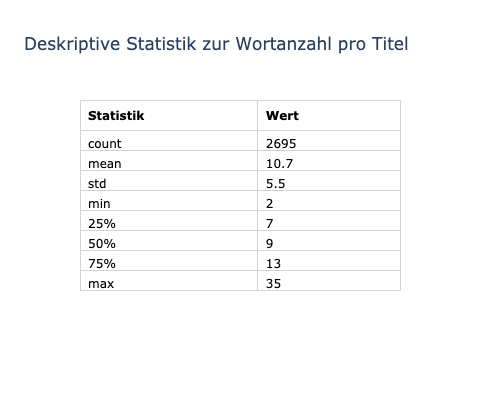

In [21]:
# Word-Count-Verteilung
df_FinanzNews_DE_Unternehmen["Wortanzahl"] = df_FinanzNews_DE_Unternehmen["Titel"].astype(str).str.split().str.len()

# Deskriptive Statistik
wort_stats = df_FinanzNews_DE_Unternehmen["Wortanzahl"].describe().round(1)

# Tabelle bauen
fig = go.Figure(data=[go.Table(
    columnwidth=[100, 80],  # manuelle Breite: Statistik, Wert
    header=dict(
        values=["<b>Statistik</b>", "<b>Wert</b>"],
        fill_color='white',
        line_color='lightgrey',
        align='left',
        font=dict(color='black', size=12)
    ),
    cells=dict(
        values=[wort_stats.index.tolist(), wort_stats.values.tolist()],
        fill_color='white', 
        line_color='lightgrey',
        align='left',
        font=dict(color='black', size=12)
    )
)])

fig.update_layout(
    title="Deskriptive Statistik zur Wortanzahl pro Titel",
    paper_bgcolor='white',
    plot_bgcolor='white',
    width=480,
    height=420
)

fig.show()

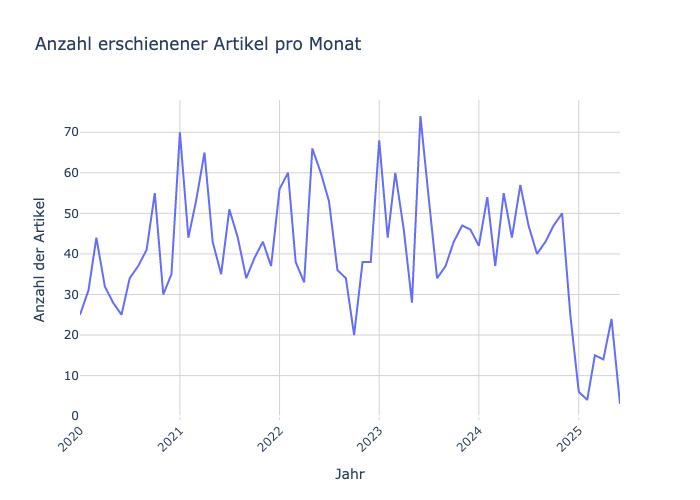

In [22]:
# Analyse der Veröffentlichungsdaten, um Trends im Laufe der Zeit zu erkennen

# Monat aus dem Datum extrahieren und als Perioden-String speichern
# Beispiel: 2025-05, 2025-06 etc.
df_FinanzNews_DE_Unternehmen["MonatJahr"] = df_FinanzNews_DE_Unternehmen["Datum"].dt.to_period("M").astype(str)

# Gruppieren nach Monat/Jahr und zählen, wie viele Artikel pro Monat erschienen sind
artikel_pro_monat = df_FinanzNews_DE_Unternehmen.groupby("MonatJahr").size().reset_index(name="Anzahl_Artikel")

# Liniendiagramm mit Plotly erzeugen
# X-Achse: Monat/Jahr (zeitliche Reihenfolge der Monate)
# Y-Achse: Anzahl der Artikel, die in diesem Monat erschienen sind
# 'markers=False' fügt keine Punkte auf der Linie hinzu, um einzelne Werte hervorzuheben
fig = px.line(
    artikel_pro_monat,
    x="MonatJahr",
    y="Anzahl_Artikel",
    title="Anzahl erschienener Artikel pro Monat",
    labels={"MonatJahr": "Jahr", "Anzahl_Artikel": "Anzahl der Artikel"},
    markers=False
)
# Weißer Hintergrund & Drehung der X-Achsen-Beschriftungen um -45 Grad, damit die Beschriftung besser lesbar ist
fig.update_layout(plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='lightgrey'),
    yaxis=dict(showgrid=True, gridcolor='lightgrey'),
    xaxis_tickangle=-45)
# Darstellung der Grafik
fig.show()

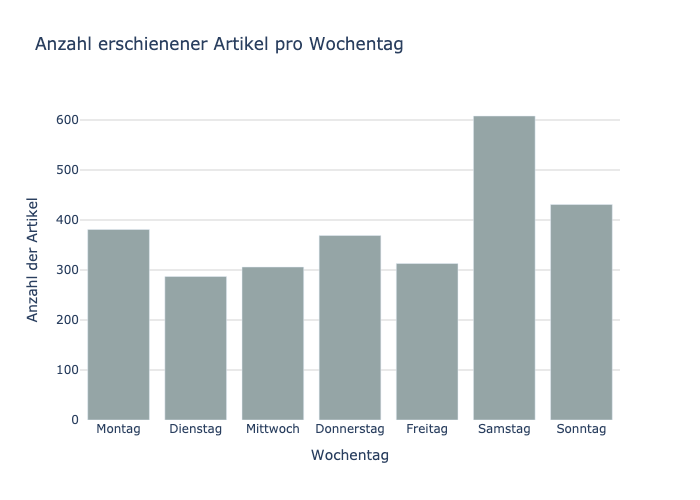

In [23]:
# Analyse der Anzahl der veröffentlichten Artikel pro Wochentag
# Wochentag (englische Namen) aus dem Datum extrahieren
df_FinanzNews_DE_Unternehmen["Wochentag_en"] = df_FinanzNews_DE_Unternehmen["Datum"].dt.day_name()

# Manuell ins Deutsche übersetzen
wochentage_map = {
    "Monday": "Montag",
    "Tuesday": "Dienstag",
    "Wednesday": "Mittwoch",
    "Thursday": "Donnerstag",
    "Friday": "Freitag",
    "Saturday": "Samstag",
    "Sunday": "Sonntag"
}

# Mapping der deutschen und englischen Wochentage
df_FinanzNews_DE_Unternehmen["Wochentag"] = df_FinanzNews_DE_Unternehmen["Wochentag_en"].map(wochentage_map)
wochentag_order = ["Montag", "Dienstag", "Mittwoch", "Donnerstag", "Freitag", "Samstag", "Sonntag"]

# Anzahl Artikel pro Wochentag zählen
artikel_pro_wochentag = df_FinanzNews_DE_Unternehmen["Wochentag"].value_counts().reindex(wochentag_order).reset_index()
artikel_pro_wochentag.columns = ["Wochentag", "Anzahl_Artikel"]

# Plotly Balkendiagramm
fig = px.bar(
    artikel_pro_wochentag,
    x="Wochentag",
    y="Anzahl_Artikel",
    title="Anzahl erschienener Artikel pro Wochentag",
    labels={"Wochentag": "Wochentag", "Anzahl_Artikel": "Anzahl der Artikel"},
    color_discrete_sequence=["#95A5A6"]
)
# Weißer Hintergrund 
fig.update_layout(plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showgrid=False, gridcolor='lightgrey'),
    yaxis=dict(showgrid=True, gridcolor='lightgrey'))

fig.show()

In [24]:
# Titel mit mehreren Unternehmen splitten (explode)
# Listen in der Spalte "Gefundene_Unternehmen" auflösen
df_explodiert = df_FinanzNews_DE_Unternehmen.explode("Gefundene_Unternehmen").reset_index(drop=True)

In [25]:
# Häufigkeit Nennung Unternehmen
# Anzahl je Unternehmen berechnen
unternehmen_counts = df_explodiert["Gefundene_Unternehmen"].value_counts()

# Sortierung nach Top-Nennung 
top5 = unternehmen_counts.head(5).reset_index()
top5.columns = ['Unternehmen', 'Anzahl']
# Anzeigen
display(top5.style.hide(axis="index"))

Unternehmen,Anzahl
Siemens,791
SAP,570
Telekom,528
Allianz,445
Rheinmetall,423


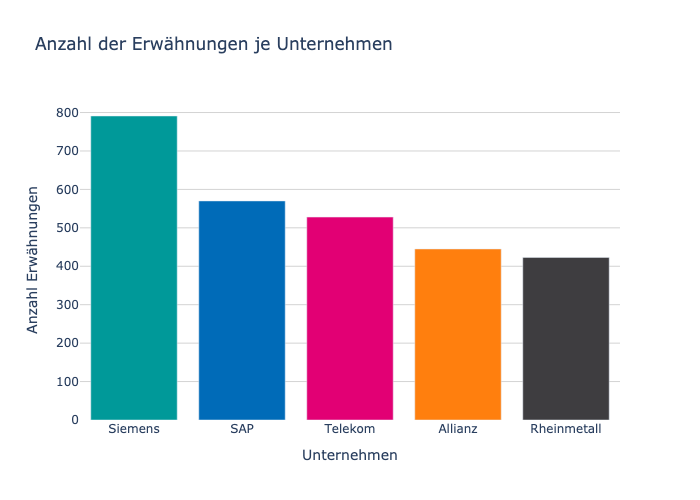

In [26]:
# Balkendiagramm I: Anzahl der Erwähnungen je Unternehmen
# Unternehmen-Counts zu DataFrame konvertieren
df_counts = unternehmen_counts.reset_index()
df_counts.columns = ["Unternehmen", "Anzahl Erwähnungen"]

# Balkendiagramm mit festen Farben
fig = px.bar(
    df_counts,
    x="Unternehmen", # x-Achse: Unternehmensnamen
    y="Anzahl Erwähnungen", # y-Achse: Anzahl der Nennungen
    color="Unternehmen", # Balkenfarbe pro Unternehmen
    color_discrete_map=farben_unternehmen, # feste Farbzuteilung (vordefiniert)
    title="Anzahl der Erwähnungen je Unternehmen",
    labels={"Unternehmen": "Unternehmen", "Anzahl Erwähnungen": "Anzahl Erwähnungen"}
)

# Weißer Hintergrund
fig.update_layout(
    showlegend=False,  # Legende optional (nicht notwendig)
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showgrid=False, gridcolor='lightgrey'),
    yaxis=dict(showgrid=True, gridcolor='lightgrey'))
fig.show()

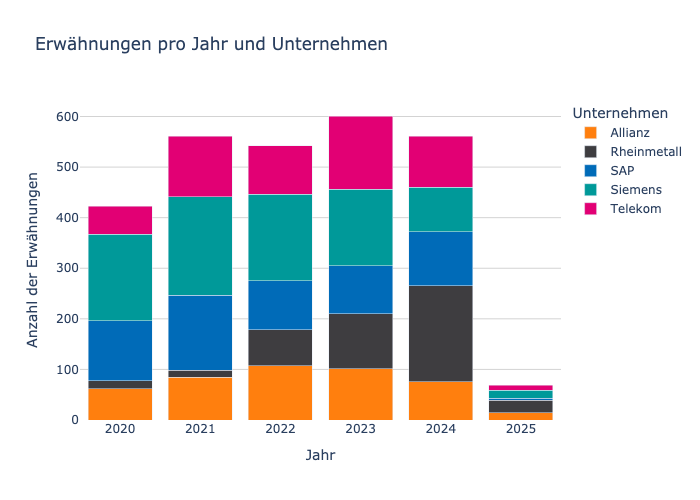

In [27]:
# Balkendiagramm II: Anzahl der Erwähnungen pro Jahr und Unternehmen
# Extrahiere das Jahr aus dem Datumsfeld in einer neuen Spalte
df_explodiert["Jahr"] = df_explodiert["Datum"].dt.year
# Gruppiere nach Jahr und Unternehmen und zähle die Anzahl der Nennungen
zeitreihe1 = df_explodiert.groupby(["Jahr", "Gefundene_Unternehmen"]).size().reset_index(name="Anzahl_Erwaehnungen")

# Gestapeltes Balkendiagramm mit Plotly
fig_bar = px.bar(
    zeitreihe1,
    x="Jahr",
    y="Anzahl_Erwaehnungen",
    color="Gefundene_Unternehmen",
    title="Erwähnungen pro Jahr und Unternehmen",
    labels={
        "Jahr": "Jahr",
        "Anzahl_Erwaehnungen": "Anzahl der Erwähnungen",
        "Gefundene_Unternehmen": "Unternehmen"
    },
    color_discrete_map=farben_unternehmen  # feste Farbcodierung
)

# Weißer Hintergrund & gestapelte Balken
fig_bar.update_layout(
    barmode="stack",  # gestapelte Balken
    legend_title_text="Unternehmen",
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showgrid=False, gridcolor='lightgrey'),
    yaxis=dict(showgrid=True, gridcolor='lightgrey')
)

fig_bar.show()

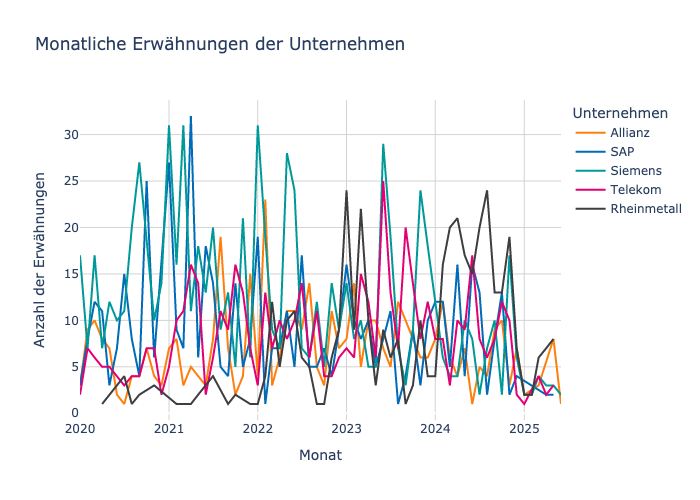

In [28]:
# Zeitreihe: Erwähnungen der Unternehmen pro Monat
# Jahr und Monat aus Datum extrahieren
df_explodiert["JahrMonat"] = df_explodiert["Datum"].dt.to_period("M")

# Gruppieren und Anzahl der Erwähnungen pro Unternehmen pro Monat berechnen
monatliche_zeitreihe = (
    df_explodiert.groupby(["JahrMonat", "Gefundene_Unternehmen"])
    .size()
    .reset_index(name="Anzahl_Erwaehnungen")
)

# JahrMonat in Datetime zurückwandeln
monatliche_zeitreihe = monatliche_zeitreihe.copy()
monatliche_zeitreihe["JahrMonat"] = monatliche_zeitreihe["JahrMonat"].dt.to_timestamp()

fig = px.line(
    monatliche_zeitreihe,
    x="JahrMonat",
    y="Anzahl_Erwaehnungen",
    color="Gefundene_Unternehmen",
    title="Monatliche Erwähnungen der Unternehmen",
    labels={
        "JahrMonat": "Monat",
        "Anzahl_Erwaehnungen": "Anzahl der Erwähnungen",
        "Gefundene_Unternehmen": "Unternehmen"
    },
    color_discrete_map=farben_unternehmen  # festgelegte Farben
)

fig.update_layout(
    annotations=[
        dict(
            text="Hinweis: Nicht alle Unternehmen sind in jedem Monat vertreten.",
            xref="paper", yref="paper",
            x=0, y=-0.4,
            showarrow=False, font=dict(size=12, color="grey")
        )
    ],
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='lightgrey'),
    yaxis=dict(showgrid=True, gridcolor='lightgrey'))

fig.show()

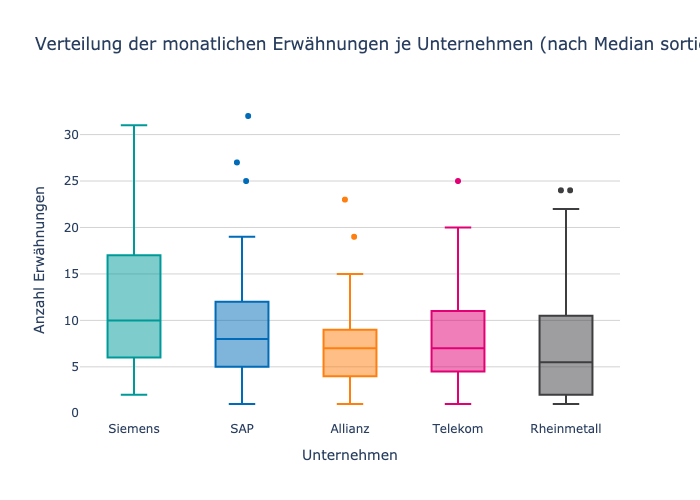

In [29]:
# Boxplots zur Erkennung von Ausreißern (Anzahl monatlicher Erwähnungen je Unternehmen)
# 1. Median der monatlichen Erwähnungen je Unternehmen berechnen
mediane = (
    monatliche_zeitreihe
    .groupby("Gefundene_Unternehmen")["Anzahl_Erwaehnungen"]
    .median() # Median der Erwähnungen pro Unternehmen
    .sort_values(ascending=False) # Absteigend sortieren (höchster Median zuerst)
)

# 2. Reihenfolge der Unternehmen basierend auf Median
unternehmen_sortiert = mediane.index.tolist() # Index enthält Unternehmensnamen in sortierter Reihenfolge

# 3. Monat als Label (für Hovertext bei Ausreißern)
monatliche_zeitreihe["Monat_label"] = monatliche_zeitreihe["JahrMonat"].dt.strftime("%B %Y")

# 4. Plot initialisieren
fig = go.Figure()

# 5. Für jedes Unternehmen (nach Median sortiert) einen Boxplot erzeugen
for unternehmen in unternehmen_sortiert:
     # Daten für das aktuelle Unternehmen herausfiltern
    df_u = monatliche_zeitreihe[monatliche_zeitreihe["Gefundene_Unternehmen"] == unternehmen]

    fig.add_trace(go.Box(
        y=df_u["Anzahl_Erwaehnungen"],
        name=unternehmen,
        marker_color=farben_unternehmen.get(unternehmen, "gray"),
        boxpoints="outliers",
        jitter=0.3,
        pointpos=0.0,
        hovertext=df_u["Monat_label"],
        hoverinfo="text+y"
    ))

# 6. Layout anpassen
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showgrid=False, gridcolor='lightgrey'),
    yaxis=dict(showgrid=True, gridcolor='lightgrey'),
    title="Verteilung der monatlichen Erwähnungen je Unternehmen (nach Median sortiert)",
    yaxis_title="Anzahl Erwähnungen",
    xaxis_title="Unternehmen",
    showlegend=False
)

fig.show()

In [30]:
# Analyse Setiments

# Farbkodierung für Sentiments
farben = {
    "Positiv": "#2ECC71",
    "Negativ": "#E74C3C",
    "Neutral": "#3498DB"
}

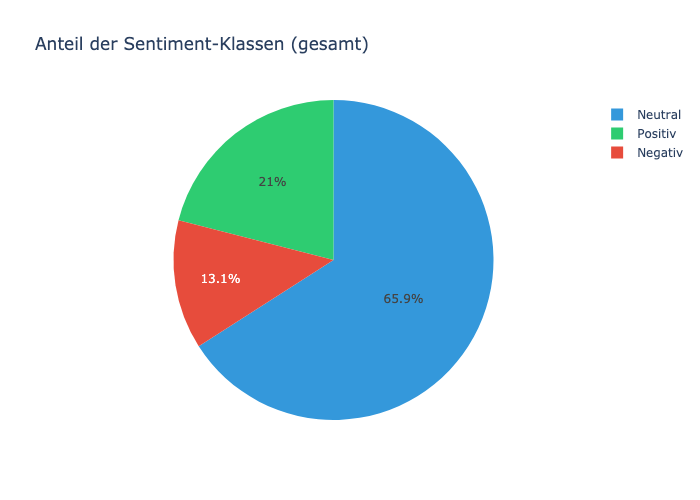

In [31]:
# Kreisdiagramm: Verteilung der Sentiments
sentiment_counts = df_FinanzNews_DE_Unternehmen["sentiment"].value_counts().reset_index()
sentiment_counts.columns = ["sentiment", "Anzahl"]

fig = px.pie(
    sentiment_counts,
    names="sentiment",
    values="Anzahl",
    title="Anteil der Sentiment-Klassen (gesamt)",
    color="sentiment",
    color_discrete_map=farben
)
fig.show()

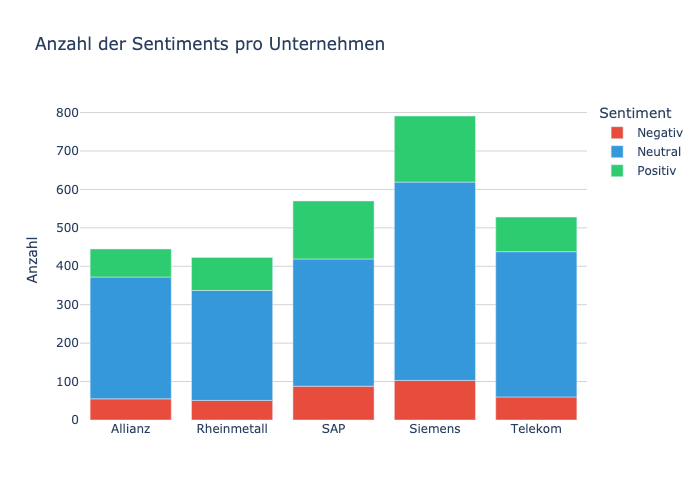

In [32]:
# Balkendiagramm: Sentiment-Verteilung pro Unternehmen 
# Zähle Sentiments je Unternehmen
df_plot1 = df_explodiert.groupby(["Gefundene_Unternehmen", "sentiment"]).size().reset_index(name="Anzahl")

# Plotly-Balkendiagramm
fig = px.bar(
    df_plot1,
    x="Gefundene_Unternehmen",
    y="Anzahl",
    color="sentiment",
    color_discrete_map=farben,
    labels={
        "unternehmen": "",        # X-Achsentitel leer lassen
        "Anzahl": "Anzahl",
        "sentiment": "Sentiment" # Legendentitel
    },
    title="Anzahl der Sentiments pro Unternehmen",
    hover_data={"Anzahl": True, "sentiment": True, "Gefundene_Unternehmen": False}
)

# Layout anpassen
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showgrid=False, gridcolor='lightgrey'),
    yaxis=dict(showgrid=True, gridcolor='lightgrey'),
    legend_title_text="Sentiment",
    xaxis_title=""
)

fig.show()

In [33]:
# Durchschnittlicher Sentiment-Wert pro Unternehmen pro Tag
# Gruppierung & Aggregation
df_agg_tag_unternehmen = df_explodiert.groupby(["Datum", "Gefundene_Unternehmen"]).agg(
    Anzahl_Artikel=("Titel", "count"),
    Mean_Sentiment=("sentiment_num", "mean"), # Durchschnittliches Sentiment je Tag
    Mean_Confidence=("confidence", "mean") # Durchschnittliche Confidence (Sentiment) je Tag
).reset_index()
df_agg_tag_unternehmen.head(10)

,Datum,Gefundene_Unternehmen,Anzahl_Artikel,Mean_Sentiment,Mean_Confidence
0,2020-01-04,SAP,1,0.000000,0.996543
1,2020-01-05,Telekom,1,0.000000,0.995941
2,2020-01-06,SAP,1,1.000000,0.993891
3,2020-01-07,Siemens,2,0.000000,0.981501
4,2020-01-08,Siemens,1,0.000000,0.993705
5,2020-01-11,Siemens,1,0.000000,0.995438
6,2020-01-12,Allianz,1,0.000000,0.997261
7,2020-01-12,Siemens,5,0.000000,0.995650
8,2020-01-13,Siemens,6,-0.166667,0.992527
9,2020-01-14,Allianz,1,0.000000,0.994978


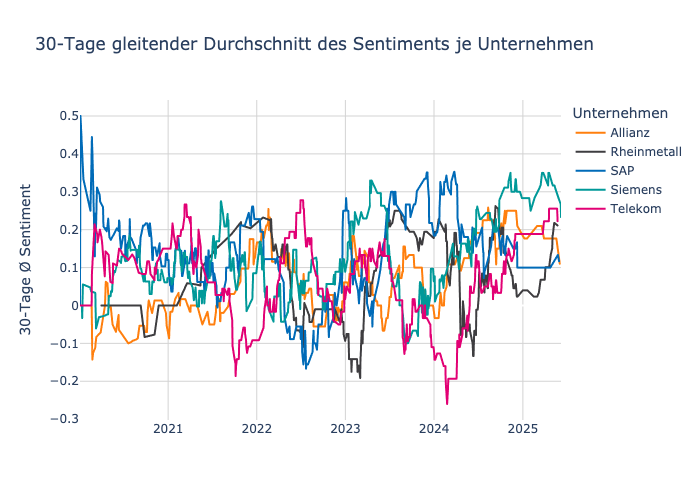

In [34]:
# Grafik: 30-Tage gleitender Durchschnitt des Sentiments je Unternehmen
# Zuerst: sicherstellen, dass die Daten nach Datum sortiert sind
df_agg_tag_unternehmen = df_agg_tag_unternehmen.sort_values(by=["Gefundene_Unternehmen", "Datum"])

# Gleitenden Durchschnitt berechnen (30 Tage)
df_agg_tag_unternehmen["Sentiment_Rolling30"] = (
    df_agg_tag_unternehmen
    .groupby("Gefundene_Unternehmen")["Mean_Sentiment"]
    .transform(lambda x: x.rolling(window=30, min_periods=1).mean())
)
fig = px.line(
    df_agg_tag_unternehmen,
    x="Datum",
    y="Sentiment_Rolling30",
    color="Gefundene_Unternehmen",
    title="30-Tage gleitender Durchschnitt des Sentiments je Unternehmen",
    labels={
        "Datum": "",
        "Sentiment_Rolling30": "30-Tage Ø Sentiment",
        "Gefundene_Unternehmen": "Unternehmen"
    },
    color_discrete_map=farben_unternehmen  # festgelegte Farben
)

fig.update_traces(mode="lines")
fig.update_layout(
    annotations=[
        dict(
            text="Hinweis: Nicht alle Unternehmen sind in jedem Monat vertreten.",
            xref="paper", yref="paper",
            x=0, y=-0.4,
            showarrow=False, font=dict(size=12, color="grey")
        )
    ],
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='lightgrey'),
    yaxis=dict(showgrid=True, gridcolor='lightgrey'))

fig.show()

In [35]:
# Speichern Dataframe
df_agg_tag_unternehmen.to_csv("df_agg_tag_unternehmen.csv", index=False)